In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
%matplotlib inline
from sys import path
path.append('/u/cm/rbertoss')
import thermocepstrum as tc
plt.rcParams['figure.figsize'] = (16, 9)
#c = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Load currents
 Currents are formatted by columns with an initial heading. The heading of a vector is 'c_Name[1] c_Name[2] c_Name[3]'

In [2]:
jfile = tc.io.LAMMPS_Current('dump1400.log', group_vectors=True)

compute TYPE all chunk/atom type
compute vcm all vcm/chunk TYPE
compute energia_cinetica all ke/atom
compute energia_potenziale all pe/atom
compute stress all stress/atom NULL virial
compute flusso all heat/flux energia_cinetica energia_potenziale stress
thermo_style custom step time pe etotal lx press temp c_flusso[1] c_flusso[2] c_flusso[3] c_vcm[1][1] c_vcm[1][2] c_vcm[1][3] c_vcm[2][1] c_vcm[2][2] c_vcm[2][3]
run 500000
Ewald initialization ...
  G vector (1/distance) = 0.183708
  estimated absolute RMS force accuracy = 1.76819e-06
  estimated relative force accuracy = 1.22794e-07
  KSpace vectors: actual max1d max3d = 1535 9 3429
                  kxmax kymax kzmax  = 9 9 9
Memory usage per processor = 20.1415 Mbytes
Step Time PotEng TotEng Lx Press Temp c_flusso[1] c_flusso[2] c_flusso[3] c_vcm[1][1] c_vcm[1][2] c_vcm[1][3] c_vcm[2][1] c_vcm[2][2] c_vcm[2][3] 
 #####################################
  all_ckeys =  {'Temp': [6], 'flusso': array([7, 8, 9]), 'vcm[1]': array([10, 11, 

In [3]:
jfile.read_currents(start_step=0, NSTEPS=int(100/0.005), select_ckeys=['flusso','vcm[1]','vcm[2]','Temp','Lx','Time'])

  ckey =  {'Temp': [6], 'flusso': array([7, 8, 9]), 'Time': [1], 'vcm[2]': array([13, 14, 15]), 'vcm[1]': array([10, 11, 12]), 'Lx': [4]}
  ( 20000 ) steps read.
DONE.  Elapsed time:  0.542402982712 seconds


{'Lx': array([[ 40.211549],
        [ 40.211549],
        [ 40.211549],
        ..., 
        [ 40.211549],
        [ 40.211549],
        [ 40.211549]]), 'Temp': array([[ 1389.7914],
        [ 1391.3327],
        [ 1392.8159],
        ..., 
        [ 1423.0464],
        [ 1420.9682],
        [ 1415.2676]]), 'Time': array([[  10.001],
        [  10.006],
        [  10.011],
        ..., 
        [ 109.986],
        [ 109.991],
        [ 109.996]]), 'flusso': array([[ 356.48776  , -481.02317  ,    3.9213785],
        [ 382.26795  , -526.27193  ,  -41.391124 ],
        [ 405.62305  , -563.2173   ,  -86.524663 ],
        ..., 
        [-932.64053  ,  536.55097  ,    5.6513975],
        [-947.04752  ,  555.63311  ,  -21.053064 ],
        [-931.43492  ,  515.98025  ,    1.549477 ]]), 'vcm[1]': array([[-0.13243469,  0.05099928, -0.15454933],
        [-0.16176343,  0.08494438, -0.17589918],
        [-0.18845167,  0.12007215, -0.20042892],
        ..., 
        [ 0.42898151, -0.09916579, -0.065

Calculate mean temperature, volume of the cell, conversion factor, timestep

In [4]:
DT_FS=(jfile.data['Time'][1]-jfile.data['Time'][0])*1000
TEMPERATURE=0.0
cont=0
for T in jfile.data['Temp']:
    cont=cont+1
    delta=T-TEMPERATURE
    TEMPERATURE=TEMPERATURE+delta/cont
VOLUME=jfile.data['Lx'][0]**3
kappa_scale = tc.md.scale_kappa_METALtoSI(TEMPERATURE, VOLUME, DT_FS)
print 'kappa_scale = {}, T={}K, DT_FS={}fs, V={}Å³'.format(kappa_scale,TEMPERATURE,DT_FS,VOLUME)
#sanity check
oldt=jfile.data['Time'][0]-(jfile.data['Time'][1]-jfile.data['Time'][0])
for t in jfile.data['Time']:
    if abs(t-oldt - (jfile.data['Time'][1]-jfile.data['Time'][0]) )> 0.0001:
        print 'Sanity check failed between times: ',oldt,t
    oldt=t

kappa_scale = [  7.31473241e-07], T=[ 1398.06728082]K, DT_FS=[ 5.]fs, V=[ 65020.81502498]Å³


Calculate the charge current (the measure unit of charge is not important, because it will simplifies out at the end)

In [5]:
#JZ = np.zero( (len(jfile.data['vcm[1]']),3) )
JZ = jfile.data['vcm[1]']-jfile.data['vcm[2]']

In [6]:
j = tc.md.MDSample(traj = jfile.data['flusso'], DT_FS=DT_FS)
jz = tc.md.MDSample(traj = JZ, DT_FS=DT_FS)
FILTER_WINDOW_WIDTH = 0.0005  # filter window width [reduced frequency units]
j.compute_kappa(other=jz,FILTER_WINDOW_WIDTH =FILTER_WINDOW_WIDTH, average_components=True)  # DT is used to normalize the new PSD


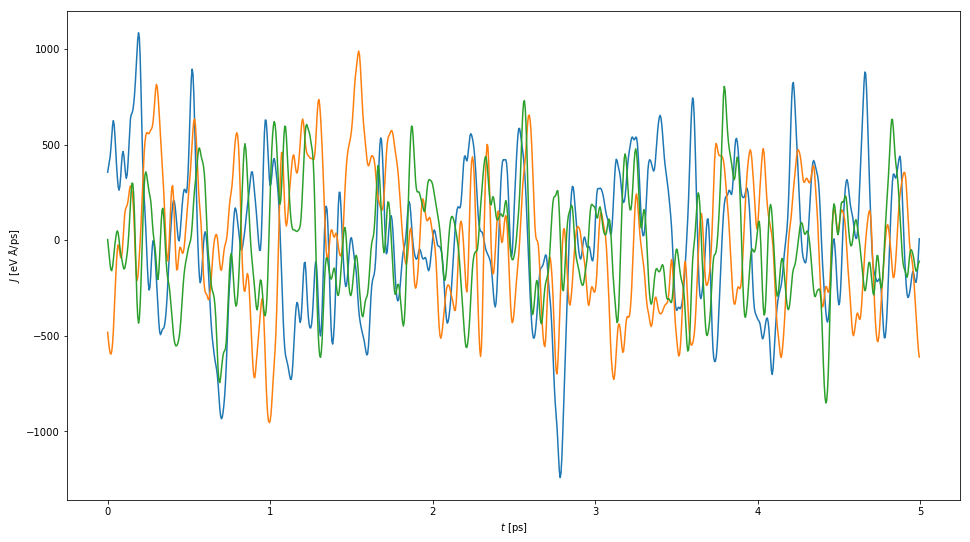

In [7]:
plt.plot(np.arange(1000)*j.DT_FS/1000., j.traj[:1000,:]);
plt.xlabel(u'$t$ [ps]')
plt.ylabel(u'$J$ [eV Å/ps]');

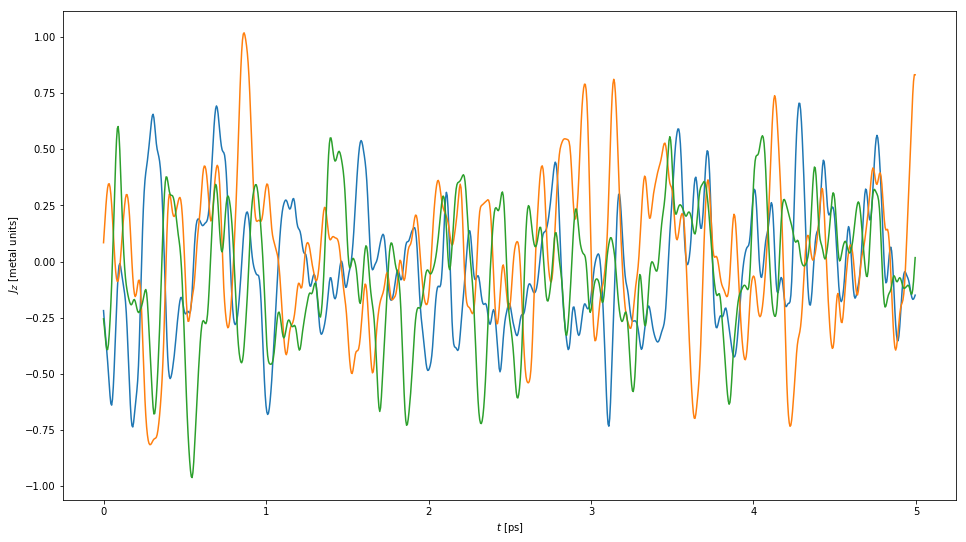

In [8]:
plt.plot(np.arange(1000)*jz.DT_FS/1000., jz.traj[:1000,:]);
plt.xlabel(u'$t$ [ps]')
plt.ylabel(u'$J_Z$ [metal units]');

Resample the trajectory and recumpute all stuff

In [9]:
TSKIP = int(round(0.5/0.08))
FILTER_WINDOW_WIDTH = 0.0005*TSKIP  # filter window width [reduced frequency units]
jf = tc.md.MDSample(traj = tc.md.tools.filter_and_sample(j.traj, TSKIP, TSKIP), DT_FS=TSKIP*DT_FS)
jzf = tc.md.MDSample(traj = tc.md.tools.filter_and_sample(jz.traj, TSKIP, TSKIP), DT_FS=TSKIP*DT_FS)
print 'Sampling time = {} steps\n              = {} fs'.format(TSKIP, TSKIP*DT_FS)

Sampling time = 6 steps
              = [ 30.] fs


In [10]:
jf.compute_kappa(other=jzf,FILTER_WINDOW_WIDTH =FILTER_WINDOW_WIDTH, average_components=True, DT=TSKIP)  # DT is used to normalize the new PSD

In [11]:
print 'There are {:d} frequencies.'.format(jf.Nfreqs)
print 'Nyquist frequency = {:f} THz'.format(jf.Nyquist_f_THz)
print 'freqs = ', jf.freqs_THz, 'THz'

There are 1667 frequencies.
Nyquist frequency = 16.666667 THz
freqs =  [  0.00000000e+00   1.00040016e-02   2.00080032e-02 ...,   1.66466587e+01
   1.66566627e+01   1.66666667e+01] THz


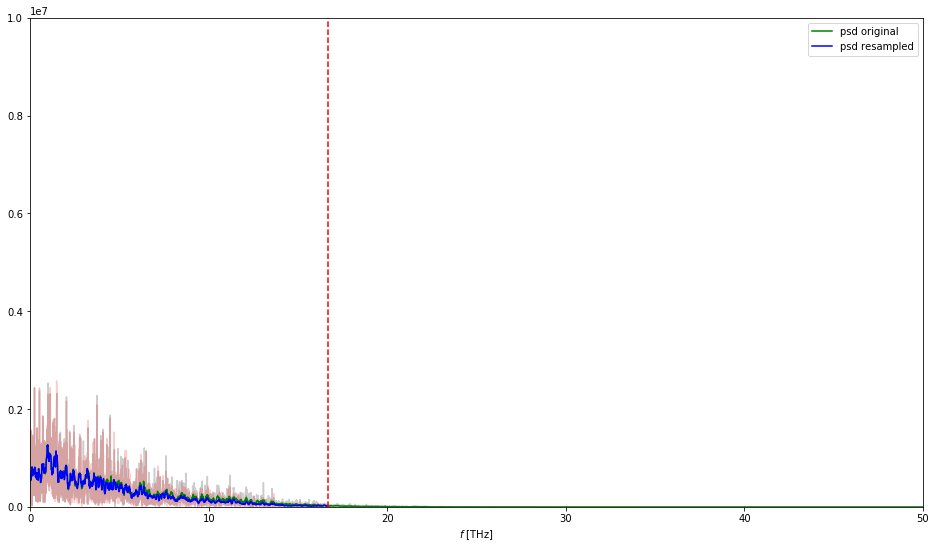

In [12]:
# PSD of resampled series (in THz)
plt.plot(j.freqs_THz, j.psd,    '0.8')
plt.plot(jf.freqs_THz, jf.psd,  c='r', alpha=0.2 )
plt.plot(j.freqs_THz,  j.fpsd,  c='g', label='psd original')
plt.plot(jf.freqs_THz, jf.fpsd, c='b', label='psd resampled')
plt.axvline(x = jf.Nyquist_f_THz, ls='--', c='r')
plt.xlim([0., 50.])
plt.ylim([0., 1e7])
plt.xlabel(r'$f$ [THz]')
plt.legend();

In [13]:
j.fpsd[0]/jf.fpsd[0]

0.98689939477669364

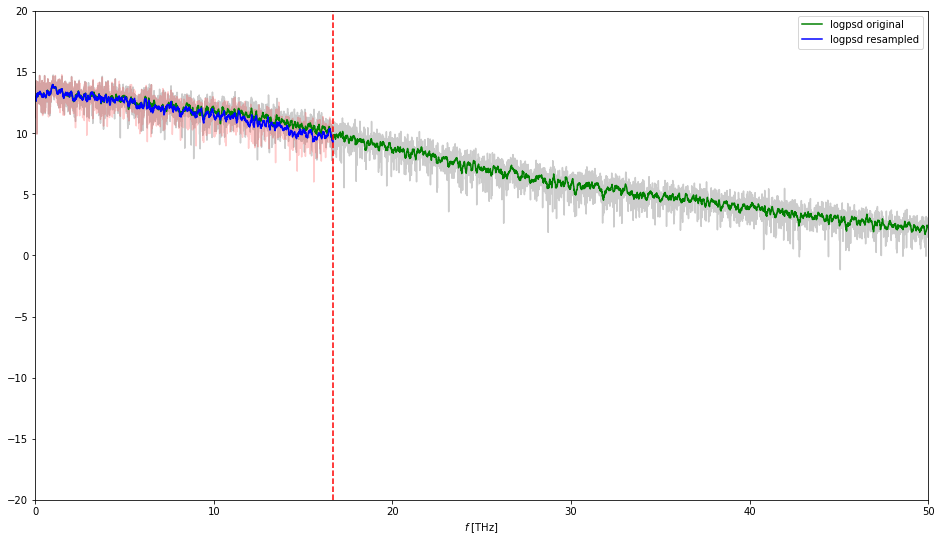

In [14]:
# PSD of resampled series (in THz)
plt.plot(j.freqs_THz, j.logpsd,    '0.8')
plt.plot(jf.freqs_THz, jf.logpsd,  c='r', alpha=0.2 )
plt.plot(j.freqs_THz,  j.flogpsd,  c='g', label='logpsd original')
plt.plot(jf.freqs_THz, jf.flogpsd, c='b', label='logpsd resampled')
plt.axvline(x = jf.Nyquist_f_THz, ls='--', c='r')
plt.xlim([0., 50.])
plt.ylim([-20, 20])
plt.xlabel(r'$f$ [THz]')
plt.legend();

# Cepstral analysis
Calculate theoretical mean and variance

In [15]:
print jf.N_COMPONENTS

3


In [16]:
ck_THEORY_var, kappa_THEORY_mean = tc.md.cepstral.multicomp_cepstral_parameters(jf.Nfreqs, (jf.N_COMPONENTS-1))

In [17]:
print ck_THEORY_var, kappa_THEORY_mean

[ 0.00038712  0.00019356  0.00019356 ...,  0.00019356  0.00019356
  0.00038712] [-0.57721566 -0.27036285 -0.27036285 ..., -0.27036285 -0.27036285
 -0.57721566]


In [18]:
print jf.logpsd

[ 11.98769346  11.25383268  13.77277545 ...,   9.23132341   9.0781177
   6.82127711]


In [19]:
jf.ddd=tc.md.cepstral.dct_coefficients(jf.logpsd)

In [20]:
jf.dct = tc.md.CosFilter(jf.logpsd, ck_theory_var=ck_THEORY_var, psd_theory_mean=kappa_THEORY_mean, \
                         aic_type='aic', Kmin_corrfactor=1.0)

In [21]:
jf.dct.logpsdK

array([  1.20023541e+01,   7.76026694e-01,  -7.25097393e-02, ...,
        -4.17385316e-03,   1.70484606e-04,   1.79152391e-02])

In [22]:
jf.ddlogtaa = tc.md.cepstral.dct_filter_tau(jf.logpsd)

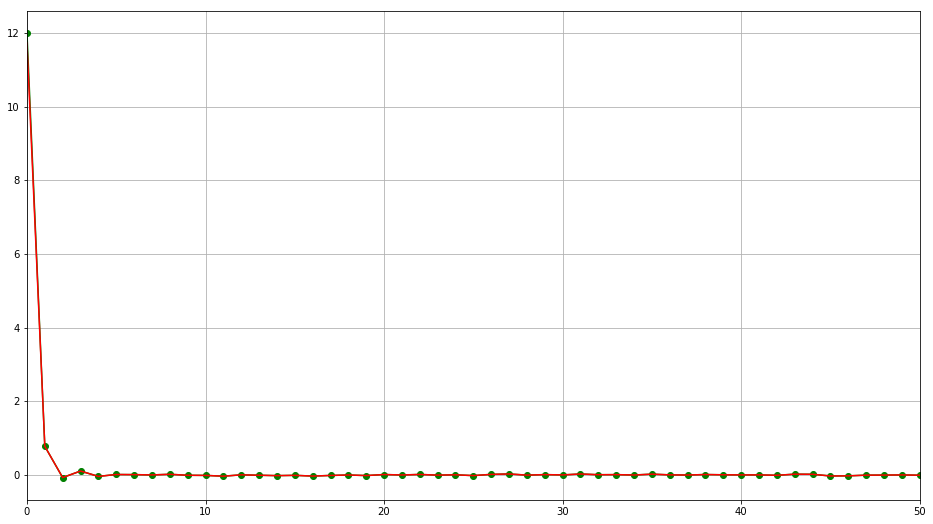

In [23]:
# Cepstral Coefficients
plt.plot(jf.dct.logpsdK, 'o-', c='g')
#plt.plot(jf.dct.logpsdK + jf.dct.logpsdK_THEORY_std, '--', c=c[0])
#plt.plot(jf.dct.logpsdK - jf.dct.logpsdK_THEORY_std, '--', c=c[0])
plt.plot(jf.ddd, 'r')
plt.xlim([0,50])
#plt.ylim([-0.8,0.8]);
plt.grid();

K of AIC_min = 4
AIC_min = 1650.998554


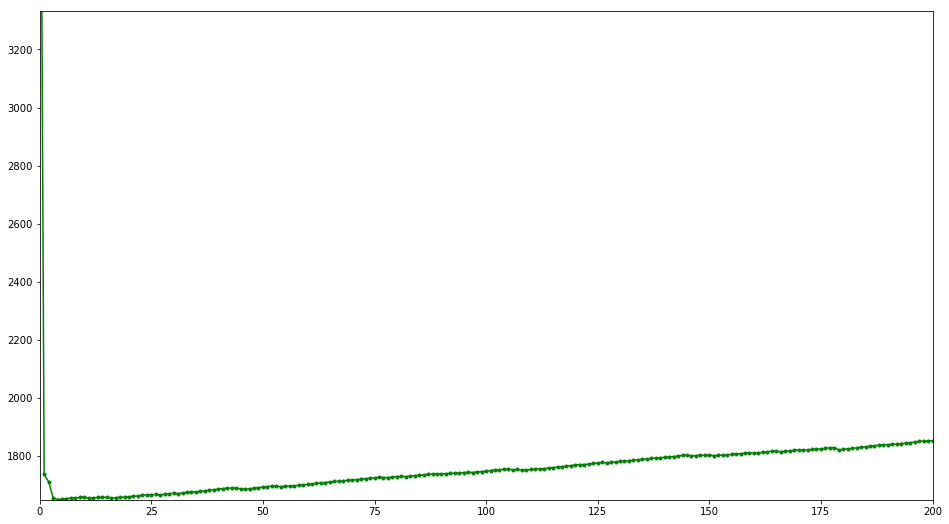

In [24]:
# AIC
plt.plot(jf.dct.aic, '.-', c='g')
plt.xlim([0,200])
plt.ylim([jf.dct.aic_min-1, jf.dct.aic[jf.dct.aic.size-1]]);

print 'K of AIC_min = {:d}'.format(jf.dct.aic_Kmin)
print 'AIC_min = {:f}'.format(jf.dct.aic_min)

In [25]:
jf.dct.scan_filter_tau()

K of AIC_min = 4
AIC_min = 1650.998554


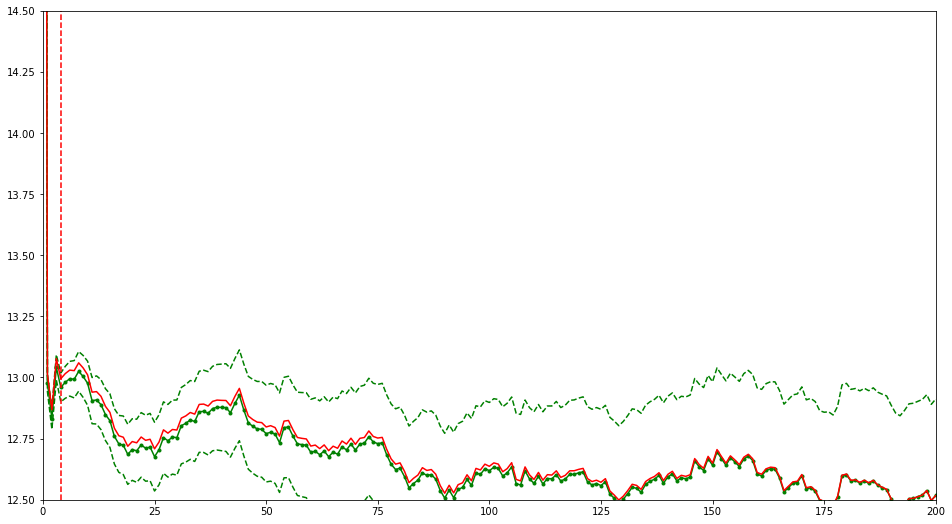

In [26]:
# L_0 as a function of cutoff K
plt.plot(jf.dct.logtau, '.-', c='g')
plt.plot(jf.dct.logtau + jf.dct.logtau_THEORY_std, '--', c='g')
plt.plot(jf.dct.logtau - jf.dct.logtau_THEORY_std, '--', c='g')
plt.plot(jf.ddlogtaa + kappa_THEORY_mean, 'r')
plt.xlim([0,200])
plt.ylim([12.5, 14.5]);
plt.axvline(x=jf.dct.aic_Kmin, ls='--', c='r')

print 'K of AIC_min = {:d}'.format(jf.dct.aic_Kmin)
print 'AIC_min = {:f}'.format(jf.dct.aic_min)

In [27]:
print 'L_0* = {:15f} +/- {:10f}'.format(jf.dct.logtau_Kmin, jf.dct.logtau_std_Kmin)
print 'S_0* = {:15f} +/- {:10f}'.format(jf.dct.tau_Kmin, jf.dct.tau_std_Kmin)

L_0* =       12.959405 +/-   0.059026
S_0* =   756623.242221 +/- 44660.244168


In [28]:
kappa_Kmin = jf.dct.tau_Kmin * kappa_scale
kappa_std_Kmin = jf.dct.tau_std_Kmin * kappa_scale
print 'kappa* = {} +/- {}  W/mK'.format(kappa_Kmin, kappa_std_Kmin)

kappa* = [ 0.55344966] +/- [ 0.03266777]  W/mK


In [29]:
kappa_Kmin[0]/0.521

1.0622834070876945

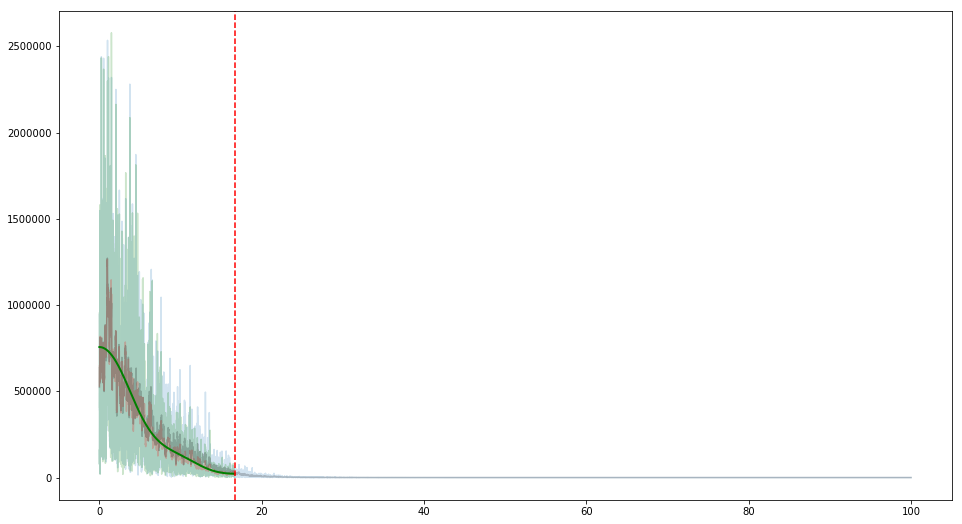

In [30]:
plt.plot(j.freqs_THz, j.psd , alpha=0.2)
plt.plot(jf.freqs_THz, jf.psd,c='g', alpha=0.2)
plt.plot(jf.freqs_THz, jf.fpsd,  c='r', alpha=0.2)
plt.plot(j.freqs_THz, j.fpsd,c='black',alpha=0.2)
plt.plot(jf.freqs_THz, jf.dct.psd, c='g', lw=2, label='filtered')
plt.axvline(x = jf.Nyquist_f_THz, ls='--', c='r')

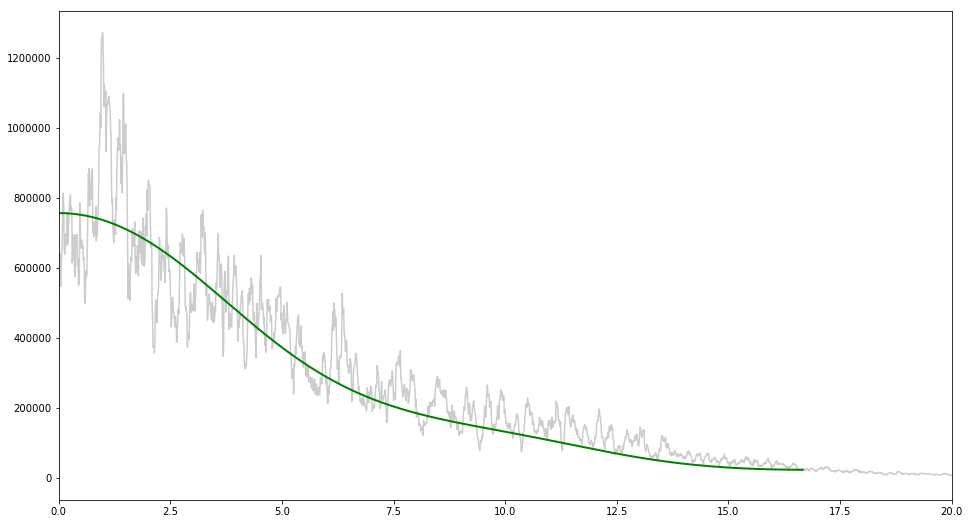

In [31]:

plt.xlim([0,20])
plt.plot(j.freqs_THz, j.fpsd,c='black',alpha=0.2)
plt.plot(jf.freqs_THz, jf.dct.psd, c='g', lw=2, label='filtered')

In [32]:
import thermocepstrum.blockanalysis

In [33]:
thermocepstrum.blockanalysis.MDBlocks()

TypeError: __init__() takes at least 8 arguments (1 given)